In [1]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib
import datetime as dt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA

In [2]:
calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
sales_train_eval = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')
sales_train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
sample_sub = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')
sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')

In [8]:
date_vars = sales_train.columns[6:] 
other_vars = sales_train.columns[:6]
print(date_vars,other_vars)

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1913) Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')


In [9]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist() #numbers of col: ['d_1814', 'd_1815',
    types = df.dtypes.values.tolist() #datatype in numbers of col: [dtype('int64'), dtype('int64'), 
    #-> for every column,their datatypes are all int64
    for i in range(len(types)): 
        if 'int' in str(types[i]):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
                
        elif 'float' in str(types[i]): 
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
                
        elif types[i] == np.object: #can be dates or categories 
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  
            

sales_train = downcast(sales_train)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

enumerate: can contain both index and the values in a columns 

## Unpivot the data

In [11]:
# sales_df = sales_train.melt(id_vars = other_vars, value_vars = date_vars, var_name = "Date")

1. ### Merge the data

In [12]:
#Join calendar data 

# calendar_to_join = calendar[['date', 'd','wm_yr_wk']]
# sales_df = pd.merge(sales_df, calendar_to_join, left_on = 'Date'  , right_on = 'd', suffixes=('_sales', '_cal')).drop(['Date'], axis = 1)

In [13]:
# sales_df = pd.merge(sales_df, sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [14]:
# sales_df.head()

## EDA

In [15]:
sales_train.shape

(30490, 1919)

Observation:

* 30490 total products
* 1913 days

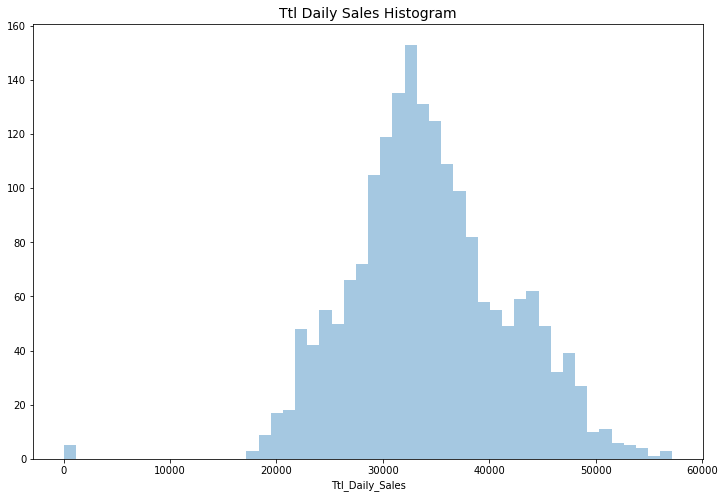

In [62]:
# Only preserve sales for days(d_1, d_2, ...)
df_day = sales_train.copy()
df_day.drop(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1, inplace = True)
df_day.describe()
df_day.loc['Ttl_Daily_Sales'] = df_day.sum() #add up the sum of the total daily sales for all items

plt.figure(figsize=(12,8))
sns.distplot(df_day.loc["Ttl_Daily_Sales"], bins=50, kde=False)
plt.title("Ttl Daily Sales Histogram", fontsize=14)
plt.show()

In [65]:
#find the 10th lowest sales 
df_day_trans = df_day.transpose()
smallest = df_day_trans.nsmallest(10, 'Ttl_Daily_Sales')
smallest['Ttl_Daily_Sales']

d_697        11
d_331        13
d_1792       14
d_1062       20
d_1427       20
d_89      17929
d_88      18113
d_90      18145
d_300     18427
d_111     18684
Name: Ttl_Daily_Sales, dtype: int64

Observation: there are some days that have extremely low sales 

### State level performance

CA    0.4
WI    0.3
TX    0.3
Name: state_id, dtype: float64


([<matplotlib.patches.Wedge at 0x7f6869875210>,
 [Text(0.33991867422268784, 1.0461621742897658, 'CA'),
  Text(-1.0461621424642782, -0.3399187721714579, 'WI'),
  Text(0.646563910834035, -0.8899185969553609, 'TX')],
 [Text(0.1854101859396479, 0.5706339132489631, '40.0%'),
  Text(-0.5706338958896062, -0.18541023936624976, '30.0%'),
  Text(0.35267122409129176, -0.4854101437938332, '30.0%')])

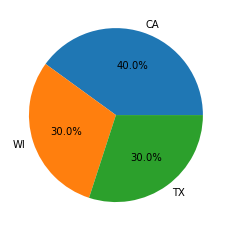

In [3]:
#Row number of each state
state_pie = sales_train['state_id'].value_counts().rename_axis('state_name').reset_index(name='counts')

#percentage of row numbers of each state
print(sales_train['state_id'].value_counts(normalize=True)) 

plt.pie(state_pie['counts'], labels= state_pie['state_name'], autopct = '%1.1f%%')



### Observe monthly sales across states

In [4]:
state = sales_train.groupby('state_id', axis = 0).sum()
state
state_trans = state.transpose()
state_trans.head()

state_id,CA,TX,WI
d_1,14195,9438,8998
d_2,13805,9630,8314
d_3,10108,6778,6897
d_4,11047,7381,6984
d_5,9925,5912,3309


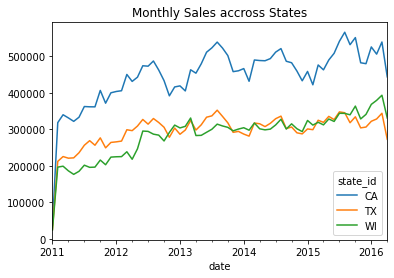

In [5]:
state_trans['date'] = pd.date_range(start='1/29/2011', periods= len(state_trans), freq='D')
state_trans.set_index('date', drop = True, inplace = True)
state_trans.sort_index(inplace=True)
state_month = state_trans.groupby(pd.Grouper(freq='1M')).sum()
state_month.head(20)
state_month.plot(title = "Monthly Sales accross States")

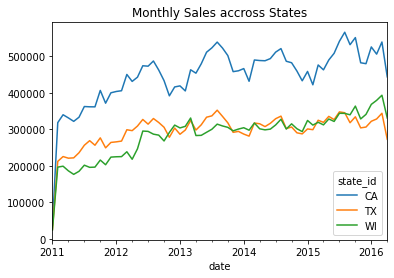

In [6]:
#Method 2

state_trans['date'] = pd.date_range(start='1/29/2011', periods= len(state_trans), freq='D')
state_trans.set_index('date', drop = True, inplace = True)
state_trans.sort_index(inplace=True)
state_trans.index.to_period("M")
state_month.plot(title = "Monthly Sales accross States")

## Store level performance

([<matplotlib.patches.Wedge at 0x7ff9e77faf10>,
 [Text(1.0263008722277691, 0.39586174311812516, 'CA_1'),
  Text(0.5867699606382722, 0.9304305526435386, 'CA_2'),
  Text(-0.26602298226244925, 1.0673480092772896, 'CA_3'),
  Text(-0.9107967628428143, 0.6168056880372056, 'CA_4'),
  Text(-1.0905087525247528, 0.1441896690713588, 'TX_1'),
  Text(-0.9751318476944, -0.509036226227668, 'TX_2'),
  Text(-0.4819245454857533, -0.9888117780742451, 'TX_3'),
  Text(0.09221220727849562, -1.0961281443466488, 'WI_1'),
  Text(0.659644667738585, -0.8802663871374687, 'WI_2'),
  Text(1.048442442409172, -0.3328189371942197, 'WI_3')],
 [Text(0.5598004757606012, 0.21592458715534096, '11.7%'),
  Text(0.3200563421663303, 0.5075075741692028, '8.7%'),
  Text(-0.14510344487042684, 0.5821898232421578, '17.0%'),
  Text(-0.4967982342778986, 0.33643946620211207, '6.2%'),
  Text(-0.5948229559225923, 0.07864891040255934, '8.5%'),
  Text(-0.5318900987423999, -0.27765612339690976, '11.0%'),
  Text(-0.26286793390131996, -0.539

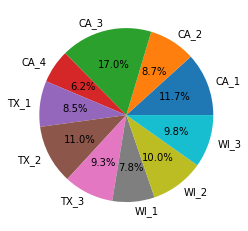

In [166]:
#Sales of each store
store_pie = sales_train.groupby('store_id').sum().T
store_pie.loc['ttl_sales'] = store_pie.sum()

plt.pie(store_pie.loc['ttl_sales'],labels = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3'], autopct = '%1.1f%%')

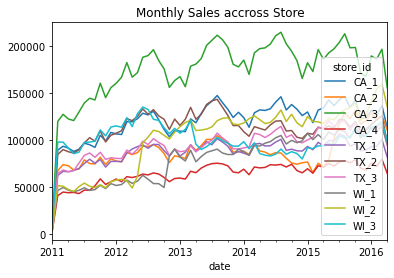

In [167]:
store = sales_train.groupby('store_id', axis = 0).sum().reset_index().set_index('store_id').T
store['date'] = pd.date_range(start='1/29/2011', periods= len(store), freq='D')
store.set_index('date', drop = True, inplace = True)
store.sort_index(inplace=True)
store_month = store.groupby(pd.Grouper(freq = '1M')).sum()
store_month.head(20)
store_month.plot(title = "Monthly Sales accross Store")

## Seasonality 

AxesSubplot(0.125,0.71587;0.775x0.16413)
AxesSubplot(0.125,0.518913;0.775x0.16413)
AxesSubplot(0.125,0.321957;0.775x0.16413)
AxesSubplot(0.125,0.125;0.775x0.16413)


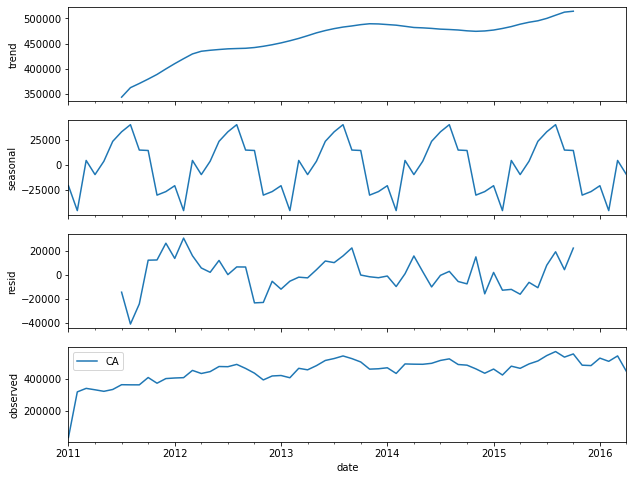

In [7]:
series = state_month['CA']
result = seasonal_decompose(series, model='additive')
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,8))
print(result.trend.plot(ax=axes[0]))
print(result.seasonal.plot(ax=axes[1]))
print(result.resid.plot(ax=axes[2]))
print(result.observed.plot(ax=axes[3]))
axes[0].set_ylabel('trend')
axes[1].set_ylabel('seasonal')
axes[2].set_ylabel('resid')
axes[3].set_ylabel('observed')

plt.legend()

### Seperate training and validation dataset

In [7]:
train_dataset = sales_train[date_vars[-100: -30]]
val_dataset = sales_train_eval[date_vars[-30:]]

In [12]:
sales_train_eval.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

In [13]:
print(train_dataset.columns)
print(val_dataset.columns)

Index(['d_1814', 'd_1815', 'd_1816', 'd_1817', 'd_1818', 'd_1819', 'd_1820',
       'd_1821', 'd_1822', 'd_1823', 'd_1824', 'd_1825', 'd_1826', 'd_1827',
       'd_1828', 'd_1829', 'd_1830', 'd_1831', 'd_1832', 'd_1833', 'd_1834',
       'd_1835', 'd_1836', 'd_1837', 'd_1838', 'd_1839', 'd_1840', 'd_1841',
       'd_1842', 'd_1843', 'd_1844', 'd_1845', 'd_1846', 'd_1847', 'd_1848',
       'd_1849', 'd_1850', 'd_1851', 'd_1852', 'd_1853', 'd_1854', 'd_1855',
       'd_1856', 'd_1857', 'd_1858', 'd_1859', 'd_1860', 'd_1861', 'd_1862',
       'd_1863', 'd_1864', 'd_1865', 'd_1866', 'd_1867', 'd_1868', 'd_1869',
       'd_1870', 'd_1871', 'd_1872', 'd_1873', 'd_1874', 'd_1875', 'd_1876',
       'd_1877', 'd_1878', 'd_1879', 'd_1880', 'd_1881', 'd_1882', 'd_1883'],
      dtype='object')
Index(['d_1884', 'd_1885', 'd_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890',
       'd_1891', 'd_1892', 'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897',
       'd_1898', 'd_1899', 'd_1900', 'd_1901', 'd_190

In [14]:
fig = make_subplots(rows = 2, cols = 1)


#first product sales from 1814 - 1883
fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values,  marker=dict(color="dodgerblue"),showlegend=False, 
               name="Original signal"),
    row=1, col=1
)

#first product sales from 1884 - 1913
fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)



#second product sales from 1814 - 1883
fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values,  marker=dict(color="dodgerblue"),showlegend=False, 
               name="Original signal"),
    row=2, col=1
)

#second product sales from 1884 - 1913
fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)


## Moving average prediction

In [69]:
def moving_average(days, train_dataset):
    predictions = []
    for i in range(days):
        if i == 0:
            predictions.append(np.mean(train_dataset[train_dataset.columns[-28:]].values, axis=1))
            #when i is 0, average the 30 days sales for every product respectively

        elif i < 28 and i > 0:
            predictions.append(
                            (np.sum(train_dataset[train_dataset.columns[-28+i:]].values,axis =1) 
                          + np.sum(predictions[:i], axis=0)) /28  )
                                
            #if i is i, we calculate the latest 29 days of average sales, and average it with predictions 
        elif i >= 28:
            predictions.append(np.mean([predictions[i-28:i]], axis=0))
        
    predictions_array = np.transpose(np.array([row.tolist() for row in predictions]))
    
    return predictions_array

In [29]:

# y_1 = val_dataset[val_dataset.columns[-30:]]
# RMSE = mean_squared_error(y_1, predictions_1)
# RMSE

### Try out first submission 

#### Validation dataset

In [8]:
validation = sales_train[date_vars[-28:]]

In [71]:
pred_val = moving_average(28, validation)
sample_sub.iloc[30490:,1:] = pred_val

In [73]:
sample_sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.178571,1.220663,1.264258,1.309410,1.284747,1.330630,1.271010,1.137832,1.178469,...,1.261713,1.235346,1.136608,1.177201,1.219244,1.262788,1.307888,1.247455,1.184865,1.227181
1,HOBBIES_1_002_CA_1_validation,0.250000,0.258929,0.232462,0.240764,0.249363,0.258268,0.267492,0.277046,0.286940,...,0.360270,0.373137,0.350749,0.291847,0.266556,0.240362,0.248946,0.257837,0.267045,0.276583
2,HOBBIES_1_003_CA_1_validation,0.750000,0.776786,0.804528,0.797547,0.790316,0.818542,0.776347,0.768360,0.795801,...,0.839316,0.833578,0.863348,0.822754,0.852138,0.882571,0.914092,0.875309,0.799427,0.827978
3,HOBBIES_1_004_CA_1_validation,1.750000,1.812500,1.877232,1.908562,1.905296,1.830485,1.860146,1.712294,1.630590,...,1.787977,1.816119,1.845266,1.911169,1.836567,1.902159,1.934379,1.896321,1.964047,1.962763
4,HOBBIES_1_005_CA_1_validation,1.392857,1.406888,1.457134,1.437746,1.381951,1.395592,1.445435,1.389914,1.368126,...,1.061298,1.099201,1.138458,1.179118,1.149800,1.155150,1.196406,1.239134,1.211961,1.219531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.214286,0.221939,0.229865,0.238075,0.246577,0.255384,0.264504,0.273951,0.283735,...,0.323649,0.263779,0.273200,0.282957,0.293063,0.303529,0.314369,0.289883,0.300236,0.310958
60976,FOODS_3_824_WI_3_evaluation,0.321429,0.332908,0.344798,0.357112,0.369866,0.383075,0.361042,0.338223,0.278873,...,0.234452,0.242825,0.251497,0.260479,0.269782,0.279417,0.289396,0.299732,0.310436,0.285809
60977,FOODS_3_825_WI_3_evaluation,0.892857,0.889031,0.920782,0.953667,0.987726,1.023002,1.023824,1.024675,0.989842,...,0.841764,0.800398,0.793270,0.821601,0.779515,0.807355,0.800475,0.829063,0.858672,0.853625
60978,FOODS_3_826_WI_3_evaluation,0.928571,0.854592,0.885113,0.916724,0.949464,0.983374,1.018494,1.019155,1.019839,...,0.943344,0.977035,1.011929,1.012355,1.048511,1.085958,1.089028,1.127922,1.061062,1.063242


#### Validation dataset

In [11]:
evaluation = sales_train_eval[sales_train_eval.columns[-28:]]

In [76]:
pred_eval = moving_average(28, evaluation)
sample_sub.iloc[:30490,1:] = pred_eval

In [79]:
sample_sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.178571,1.220663,1.264258,1.309410,1.284747,1.330630,1.271010,1.137832,1.178469,...,1.261713,1.235346,1.136608,1.177201,1.219244,1.262788,1.307888,1.247455,1.184865,1.227181
1,HOBBIES_1_002_CA_1_validation,0.250000,0.258929,0.232462,0.240764,0.249363,0.258268,0.267492,0.277046,0.286940,...,0.360270,0.373137,0.350749,0.291847,0.266556,0.240362,0.248946,0.257837,0.267045,0.276583
2,HOBBIES_1_003_CA_1_validation,0.750000,0.776786,0.804528,0.797547,0.790316,0.818542,0.776347,0.768360,0.795801,...,0.839316,0.833578,0.863348,0.822754,0.852138,0.882571,0.914092,0.875309,0.799427,0.827978
3,HOBBIES_1_004_CA_1_validation,1.750000,1.812500,1.877232,1.908562,1.905296,1.830485,1.860146,1.712294,1.630590,...,1.787977,1.816119,1.845266,1.911169,1.836567,1.902159,1.934379,1.896321,1.964047,1.962763
4,HOBBIES_1_005_CA_1_validation,1.392857,1.406888,1.457134,1.437746,1.381951,1.395592,1.445435,1.389914,1.368126,...,1.061298,1.099201,1.138458,1.179118,1.149800,1.155150,1.196406,1.239134,1.211961,1.219531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.214286,0.221939,0.229865,0.238075,0.246577,0.255384,0.264504,0.273951,0.283735,...,0.323649,0.263779,0.273200,0.282957,0.293063,0.303529,0.314369,0.289883,0.300236,0.310958
60976,FOODS_3_824_WI_3_evaluation,0.321429,0.332908,0.344798,0.357112,0.369866,0.383075,0.361042,0.338223,0.278873,...,0.234452,0.242825,0.251497,0.260479,0.269782,0.279417,0.289396,0.299732,0.310436,0.285809
60977,FOODS_3_825_WI_3_evaluation,0.892857,0.889031,0.920782,0.953667,0.987726,1.023002,1.023824,1.024675,0.989842,...,0.841764,0.800398,0.793270,0.821601,0.779515,0.807355,0.800475,0.829063,0.858672,0.853625
60978,FOODS_3_826_WI_3_evaluation,0.928571,0.854592,0.885113,0.916724,0.949464,0.983374,1.018494,1.019155,1.019839,...,0.943344,0.977035,1.011929,1.012355,1.048511,1.085958,1.089028,1.127922,1.061062,1.063242


put the prediction in sample_sub

In [66]:
filename = 'M5_2.csv'

sample_sub.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: M5_2.csv


In [ ]:
sample_sub

In [67]:
from IPython.display import FileLink
FileLink(r'M5_2.csv')

/kaggle/working/M5_2.csv

### Explonential smoothing model

In [28]:
def Explo_smoothing(train_data):
    exp_predictions = []
    for rows in range(len(train_data)): 
        fit1 = ExponentialSmoothing(train_data.iloc[rows].values, seasonal_periods=28).fit(smoothing_level = 0.2)
        exp_predictions.append(fit1.forecast(28))
    return exp_predictions

In [26]:
pred_exp = Explo_smoothing(validation)

In [27]:
pred_evl_exp = Explo_smoothing(evaluation)

In [20]:
sample_sub.iloc[:30490,1:] = pred_evl_exp
sample_sub.iloc[30490:,1:] = pred_exp

In [22]:
sample_sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,...,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854,1.193854
1,HOBBIES_1_002_CA_1_validation,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,...,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996,0.239996
2,HOBBIES_1_003_CA_1_validation,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,...,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887,0.968887
3,HOBBIES_1_004_CA_1_validation,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,...,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934,2.345934
4,HOBBIES_1_005_CA_1_validation,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,...,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163,0.806163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,...,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129,0.378129
60976,FOODS_3_824_WI_3_evaluation,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,...,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975,0.208975
60977,FOODS_3_825_WI_3_evaluation,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,...,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621,0.536621
60978,FOODS_3_826_WI_3_evaluation,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,...,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491,1.397491


In [23]:
filename = 'M5_3.csv'

sample_sub.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: M5_3.csv


In [24]:
from IPython.display import FileLink
FileLink(r'M5_3.csv')

/kaggle/working/M5_3.csv